## 1日の中で時間ごとの歩数の遷移をモデル化する

In [16]:
%matplotlib inline
import random
import numpy
import matplotlib.pylab as plt
from sklearn import manifold, datasets
from sklearn.cluster import AgglomerativeClustering
import sys
import Levenshtein
import pickle

### 杉山先生がランダム9人の10日間の歩数を時間ごとに出してはった

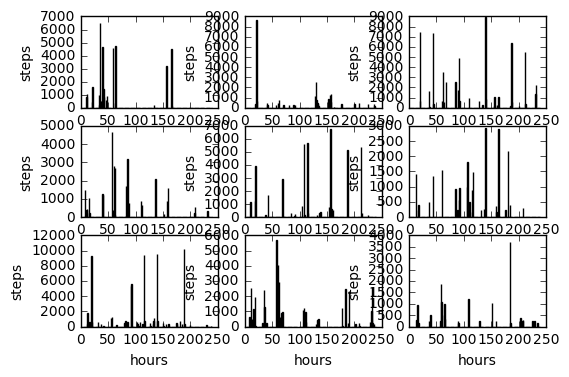

In [2]:
f = open('datasets.npz', 'rb')
dataset = numpy.load(f)
X = dataset['all']

f, axes = plt.subplots(3, 3)
for i in range(3):
    for j in range(3):
        datasets = X[random.randint(0, X.shape[0] - 1)]
        # print 'dataset: ', dataset
        axes[i][j].bar(xrange(240), datasets)
        axes[i][j].set_xlabel('hours')
        axes[i][j].set_ylabel('steps')
plt.show()

### 10日の中で1時間ごとの歩数のヒストグラムを作成

In [3]:
#print X.shape
daily_steps = X
#print daily_step.shape
daily_step = daily_steps[daily_steps != 0.0]
#daily_steps.reshape(-1,)
#numpy.ravel(daily_steps)
#print daily_steps.shape

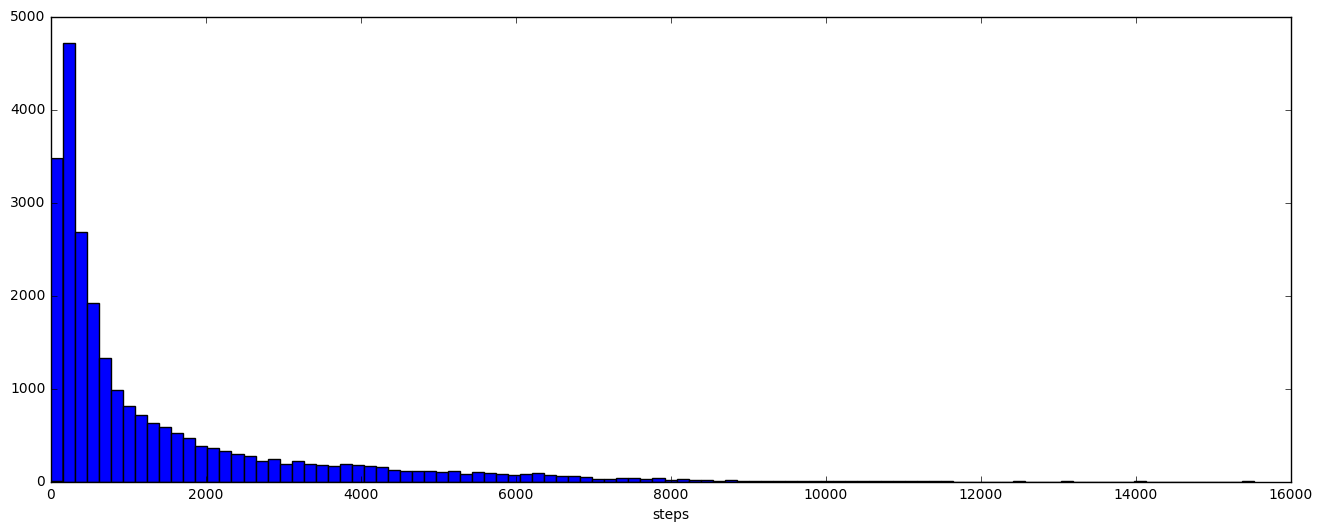

In [4]:
plt.figure(figsize=(16,6))
plt.hist(daily_step, bins=100)
plt.xlabel('steps')
#plt.xticks([156, 495, 1008, 1717, 2742, 4030, 5609, 8166])
plt.show()

In [5]:
print numpy.max(daily_step)

15520.7


### 歩数を人の状態として捉えるためにK-meansでクラスタリング

In [6]:
import scipy.cluster

#daily_step_1d = daily_step.reshape((-1, ))
#print daily_step_1d.shape
#とりあえずk=8でやる
codebook, destortion = scipy.cluster.vq.kmeans(daily_step, 8)
#ちなみに16クラスタ、32クラスタでもクラスタリング可能っぽい
#codebook, destortion = scipy.cluster.vq.kmeans(daily_step_1d, 8)
codebook = numpy.sort(codebook)
print codebook

#code, dist = scipy.cluster.vq.vq(daily_step_1d, codebook)
#print code, dist

[  180.69206238   568.73937988  1174.76794434  1943.31091309  2940.53515625
  4172.16845703  5840.09667969  8324.62207031]


In [7]:
import collections

code, dist = scipy.cluster.vq.vq(daily_step, codebook)
print collections.Counter(code)

Counter({0: 9466, 1: 5293, 2: 3111, 3: 2242, 4: 1586, 5: 1353, 6: 1050, 7: 376})


In [8]:
clus0 = []
clus1 = []
clus2 = []
clus3 = []
clus4 = []
clus5 = []
clus6 = []
clus7 = []

for i, j in zip(code, daily_step):
    if i == 0:
        clus0.append(j)
    elif i == 1:
        clus1.append(j)
    elif i == 2:
        clus2.append(j)
    elif i == 3:
        clus3.append(j)
    elif i == 4:
        clus4.append(j)
    elif i == 5:
        clus5.append(j)
    elif i == 6:
        clus6.append(j)
    elif i == 7:
        clus7.append(j)

In [9]:
print max(clus7)

15520.7


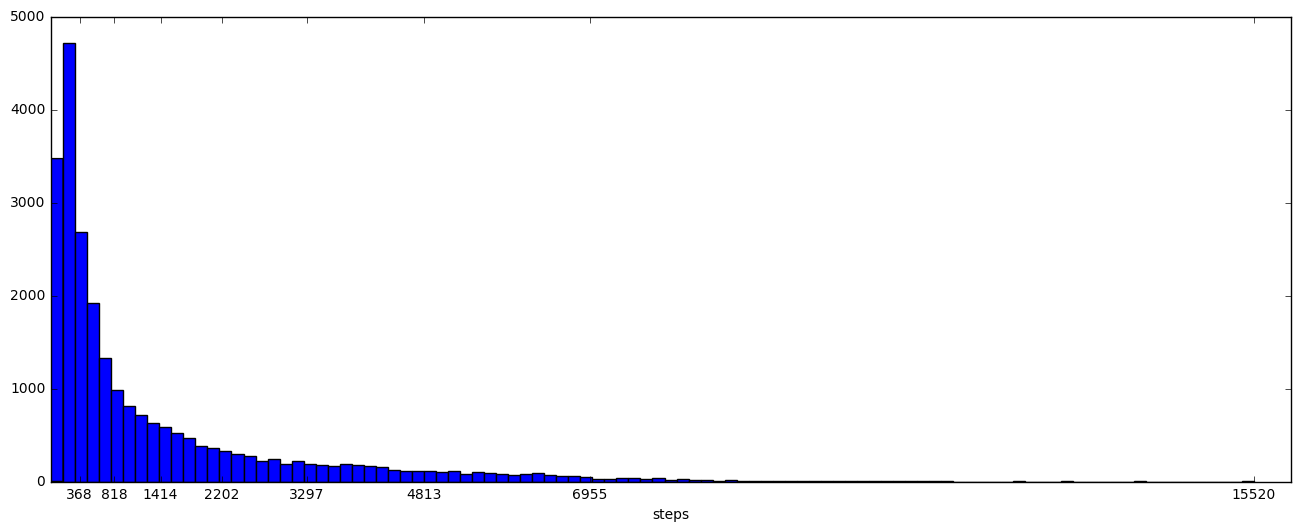

In [10]:
plt.figure(figsize=(16,6))
plt.hist(daily_step, bins=100)
plt.xlabel('steps')
plt.xticks([368, 818, 1414, 2202, 3297, 4813, 6955, 15520])
plt.show()

### 1日8000歩達成した人と未完の人を分けて１日のクラスタ遷移を見る
使ってない(7/7現在)

In [12]:
#まず1日8000歩達成した人としていない人を分けよう
kampo_daily = numpy.zeros((0, 24))
mikan_daily = numpy.zeros((0, 24))

for step in daily_step:
    if numpy.sum(step) >= 8000:
        kampo_daily = numpy.vstack((kampo_daily, step))
        
    else:
        mikan_daily = numpy.vstack((mikan_daily, step))

ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [238]:
kampo_tra = numpy.zeros((0, 24))
mikan_tra = numpy.zeros((0, 24))

#1日8000歩以上歩いた人
for name in kampo_daily:
    code, dist = scipy.cluster.vq.vq(name, codebook)
    kampo_tra = numpy.vstack((kampo_tra, code))
    
for name in mikan_daily:
    code, dist = scipy.cluster.vq.vq(name, codebook)
    mikan_tra = numpy.vstack((mikan_tra, code))
    
print "kampo user: "
for i in range(3):
    print kampo_tra[random.randint(0, kampo_tra.shape[0] - 1)]

print "mikan user: "
for i in range(3):
    print mikan_tra[random.randint(0, mikan_tra.shape[0] - 1)]

kampo user: 
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  7.  1.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  2.  0.  0.  0.  0.  3.  0.  0.  0.  6.
  0.  0.  5.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  6.  6.  1.  0.  0.]
mikan user: 
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  1.  0.  0.  0.]


### 10日間の中で遷移パターンに落とし込む

In [11]:
# まずは10日の1時間ごとのデータを24時間ごとに分割
test_ary = daily_steps
#print test_ary.shape[0]
test_ary = test_ary.reshape((-1, 24))
print daily_steps.shape
print test_ary.shape

(704, 240)
(7040, 24)


In [50]:
# テストデータを5日目以降のデータとするために、ここで5日目以前と5日目以降のデータに分ける
before_5 = daily_steps[:, :120]
after_5 = daily_steps[:, 120:]
print before_5.shape

before_daily = before_5.reshape((-1, 24))
after_daily = after_5.reshape((-1, 24))
print before_daily.shape

(704, 120)
(3520, 24)


In [ ]:
# 24時間ごとのデータに対して遷移パターンを作成
daily_trans = numpy.zeros((0, 24))

for name in test_ary:
    code, dist = scipy.cluster.vq.vq(name, codebook)
    daily_trans = numpy.vstack((daily_trans, code))
    
print daily_trans.shape
#print test_ary[1]
#print daily_trans[1]

In [13]:
# 編集距離を用いてward法でクラスタリング
sys.setrecursionlimit(10000)

pdis = scipy.spatial.distance.pdist(daily_trans, lambda i, j: Levenshtein.distance(','.join(map(str,i)), ','.join(map(str,j))))
# resultはscipyのward法でクラスタリングした結果
result = scipy.cluster.hierarchy.ward(pdis)

KeyboardInterrupt: 

In [19]:
# クラスタリング結果をpickleに保存
with open('ward_result.pkl', mode='wb') as f:
    pickle.dump(result, f)

In [415]:
print daily_trans.shape
print result.shape

(7040, 24)


/var/lib/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [15]:
with open('ward_result.pkl', mode='rb') as f:
    result = pickle.load(f)
print result

NameError: name 'pickle' is not defined

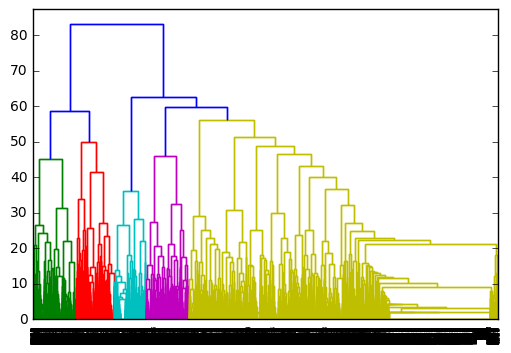

In [36]:
# デンドログラムで見てみたら、まぁまぁいい感じに分かれてそう
dendro = scipy.cluster.hierarchy.dendrogram(result)
plt.xlabel=("datas")
plt.ylabel=("distance")
scipy.cluster.hierarchy.dendrogram(result)
plt.show()
#scipy.cluster.hierarchy.dendrogram(result, p=10, truncate_mode='lastp')

### このクラスタリングが人が見てわかるクラスタリングになっているか確認する

In [58]:
# とりあえずデンドロの色分けにしたがって5クラスタでデータ分ける
#print scipy.cluster.hierarchy.leaves_list(result).shape
#print dendro["color_list"]
#cutree = scipy.cluster.hierarchy.cut_tree(result, n_clusters=[5, 2])
#print cutree.shap
tot = scipy.cluster.hierarchy.to_tree(result)
print tot

<scipy.cluster.hierarchy.ClusterNode instance at 0x7fcde7116a70>


In [51]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

### テスト用のデータ作ろう

全体の10%の人数で4時間ごとに揃ったデータを作成(70人、4時、8時、12時、16時、20時のときのデータ)

In [231]:
# 元データtest_ary shape=(7040, 24)
# まずはランダムに70人のデータ取ってこよう
target_data = numpy.zeros((0, 24))
target_num = numpy.zeros((0, 1))
for i in range(70):
    rand = random.randint(0, after_5.shape[0]-1)
    target_num = numpy.vstack((target_num, rand))
    target_data = numpy.vstack((target_data, after_5[rand, :24]))
    
print target_data.shape

# target_dataを4時間おきの不完全データにする。
target_4am = target_data[:, :4]
target_8am = target_data[:, :8]
target_12pm = target_data[:, :12]
target_4pm = target_data[:, :16]
target_8pm = target_data[:, :20]

(70, 24)


### 総当たりで似ているパターンを探してくるコード　対照群A

In [232]:
# テストデータの部分が同じ、かつ8000歩を達成しているパターンをそれぞれ10個ずつ取ってくる
def matched_data(daily, sample):
    similar_dict = {}
    count = 0
    
    for target in sample:
        similar_data = numpy.zeros((0, 24))
        euc_dist = numpy.zeros((0, 1))
        for ary in daily:
            #テストパターンと一致しており、かつ8000歩達成
            if (target == ary[:target.shape[0]]).all() and sum(ary) >= 8000:
                similar_data = numpy.vstack((similar_data, ary))
        #候補が10個以上の時はランダムに10個まで絞り込む
        if similar_data.shape[0] > 10:
            similar = numpy.zeros((0, 24))
            for i in range(10):
                similar = numpy.vstack((similar, similar_data[random.randint(0, similar_data.shape[0]-1)]))
            similar_dict[count] = similar
            count += 1
        #候補が10個に満たない時は、ユークリッド距離の上位を10個になるまで取ってくる
        elif similar_data.shape[0] < 10:
            for ary in daily:
                #テストパターンと類似しており、かつ8000歩達成
                dist_sum = 0
                for x, y in zip(target, ary[:target.shape[0]]):
                    dist_sum += x - y
                euc_dist = numpy.append(euc_dist, abs(dist_sum/len(target)))
            euc_dist = numpy.argsort(euc_dist)
            counter = 0
            while similar_data.shape[0] < 10:
                if sum(daily[euc_dist[counter]]) >= 8000:
                    similar_data = numpy.vstack((similar_data, daily[euc_dist[counter]]))
                    counter += 1
                else:
                    counter += 1
            similar_dict[count] = similar_data
            count += 1
        else:
            similar_dict[count] = similar_data
            count += 1
    
    return similar_dict

In [233]:
similar_dict_4am = matched_data(test_ary, target_4am)
print "end4am"
similar_dict_8am = matched_data(test_ary, target_8am)
print "end8am"
similar_dict_12pm = matched_data(test_ary, target_12pm)
print "end12pm"
similar_dict_4pm = matched_data(test_ary, target_4pm)
print "end4pm"
similar_dict_8pm = matched_data(test_ary, target_8pm)
print "end8pm"
#print similar_dict_4am[0]
#print similar_dict_8pm[0]

end4am
end8am
end12pm
end4pm
end8pm


In [234]:
#似てる上位10個ずつは出せたから、元データとの距離を計算
dist_4am_dict = {}
for i, target in enumerate(target_data):
    dist_4am = numpy.zeros((0, 1))
    
    for similar in similar_dict_4am[i]:
        summer = 0
        
        for data1, data2 in zip(target, similar):
            #summer += abs(data1 - data2)
            summer += data1 - data2
            #dist_4am = numpy.append(dist_4am, numpy.linalg.norm(similar-target))
        dist_4am = numpy.append(dist_4am, summer)
    dist_4am_dict[i] = dist_4am

length = 0
result = 0
summer = 0
for i in range(70):
    summer += sum(dist_4am_dict[i])
    length += len(dist_4am_dict[i])
print abs(summer/length)
#print dist_4am.shape
#print target_data.shape
totaldist_random = abs(summer/length)

9199.32008285


In [235]:
dist_8am_dict = {}
for i, target in enumerate(target_data):
    dist_8am = numpy.zeros((0, 1))
    
    for similar in similar_dict_8am[i]:
        summer = 0
        
        for data1, data2 in zip(target, similar):
            summer += data1 - data2
            #dist_4am = numpy.append(dist_4am, numpy.linalg.norm(similar-target))
        dist_8am = numpy.append(dist_8am, summer)
    dist_8am_dict[i] = dist_8am

length = 0
result = 0
summer = 0
for i in range(70):
    summer += sum(dist_8am_dict[i])
    length += len(dist_8am_dict[i])
print abs(summer/length)
totaldist_random = numpy.append(totaldist_random, abs(summer/length))

dist_12pm_dict = {}
for i, target in enumerate(target_data):
    dist_12pm = numpy.zeros((0, 1))
    
    for similar in similar_dict_12pm[i]:
        summer = 0
        
        for data1, data2 in zip(target, similar):
            summer += data1 - data2
            #dist_4am = numpy.append(dist_4am, numpy.linalg.norm(similar-target))
        dist_12pm = numpy.append(dist_12pm, summer)
    dist_12pm_dict[i] = dist_12pm

length = 0
result = 0
summer = 0
for i in range(70):
    summer += sum(dist_12pm_dict[i])
    length += len(dist_12pm_dict[i])
print abs(summer/length)
totaldist_random = numpy.append(totaldist_random, abs(summer/length))

dist_4pm_dict = {}
for i, target in enumerate(target_data):
    dist_4pm = numpy.zeros((0, 1))
    
    for similar in similar_dict_4pm[i]:
        summer = 0
        
        for data1, data2 in zip(target, similar):
            summer += data1 - data2
            #dist_4am = numpy.append(dist_4am, numpy.linalg.norm(similar-target))
        dist_4pm = numpy.append(dist_4pm, summer)
    dist_4pm_dict[i] = dist_4pm

length = 0
result = 0
summer = 0
for i in range(70):
    summer += sum(dist_4pm_dict[i])
    length += len(dist_4pm_dict[i])
print abs(summer/length)
totaldist_random = numpy.append(totaldist_random, abs(summer/length))

dist_8pm_dict = {}
for i, target in enumerate(target_data):
    dist_8pm = numpy.zeros((0, 1))
    
    for similar in similar_dict_8pm[i]:
        summer = 0
        
        for data1, data2 in zip(target, similar):
            summer += data1 - data2
            #dist_4am = numpy.append(dist_4am, numpy.linalg.norm(similar-target))
        dist_8pm = numpy.append(dist_8pm, summer)
    dist_8pm_dict[i] = dist_8pm

length = 0
result = 0
summer = 0
for i in range(70):
    summer += sum(dist_8pm_dict[i])
    length += len(dist_8pm_dict[i])
print abs(summer/length)
totaldist_random = numpy.append(totaldist_random, abs(summer/length))

8823.34589461
7424.13708985
6766.5900173
6150.57014243


<Container object of 5 artists>

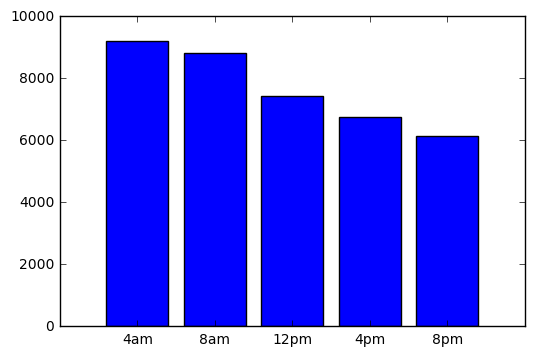

In [236]:
# 全体の平均を棒グラフで表示
labels = ['4am', '8am', '12pm', '4pm', '8pm']
plt.bar([1,2,3,4,5], totaldist_random, tick_label=labels, align='center')

### 量子化せずにクラスタリングした中から似ているパターンを探してくる　対照群B

In [23]:
def plot_clustering(X_red, X, labels, title=None):
    x_min, x_max = numpy.min(X_red, axis=0), numpy.max(X_red, axis=0)
    X_red = (X_red - x_min) / (x_max - x_min)

    plt.figure(figsize=(6, 4))
    for i in range(X_red.shape[0]):
        plt.text(X_red[i, 0], X_red[i, 1], 'a',
                 color=plt.cm.spectral(labels[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    plt.xticks([])
    plt.yticks([])
    if title is not None:
        plt.title(title, size=17)
    plt.axis('off')
    plt.tight_layout()

In [29]:
# 対象データはtest_ary
# まず量子化していないデータをクラスタリングする with ward法　ユークリッド距離
#X_red = manifold.SpectralEmbedding(n_components=2).fit_transform(test_ary)
clustering = AgglomerativeClustering(linkage='ward', n_clusters=10)
clus = clustering.fit_predict(test_ary)
print test_ary.shape
print clus.shape

#plot_clustering(X_red, test_ary, clustering.labels_, "ward")

(7040, 24)
(7040,)


In [32]:
# データをクラスタごとに分けましょう　とりあえず10クラスタ
test_cluster = {}

for label, data in zip(clus, test_ary):
    if test_cluster.get(label) is None:
        test_cluster[label] = data
    else:
        test_cluster[label] = numpy.vstack((test_cluster[label], data))
        
#print test_cluster

{0: array([[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   7.79000000e+02,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          1.57880017e+03,   1.99817792e-01,   0.00000000e+00],
       ..., 
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00]], dtype=float32), 1: array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0., 

In [39]:
# 似ているのが多いクラスタ内から上位10個を選んでくる　これなし
'''
def match_with_cluster(clus_dict, sample, num):
    similar_dict = {}
    for target in sample:
        similar_data = numpy.zeros((0, 24))
        match_ary = numpy.zeros((0, 1))
        for i in range(num):
            count = 0
            for ary in clus_dict[i]:
                if (target == ary[:target.shape[0]]).all() and sum(ary) >= 8000:
                    count += 1
            match_ary = numpy.append(match_ary, count)
            
        j = numpy.argsort(match_ary)[0]
        for ary in clus_dict[j]:
            if (target == ary[:target.shape[0]]).all() and sum(ary) >= 8000:
                similar_data = numpy.vstack((similar_data, ary))
        #候補が10個以上の時はランダムに10個まで絞り込む
        if similar_data.shape[0] > 10:
            similar = numpy.zeros((0, 24))
            for i in range(10):
                similar = numpy.vstack((similar, similar_data[random.randint(0, similar_data.shape[0]-1)]))
            similar_dict[count] = similar
            count += 1
        else:
            similar_dict[count] = similar_data
            count += 1
            
    return similar_dict
'''

In [224]:
# 過去4日間のデータがより多く属しているクラスタを検索対象とする
def matching_with_cluster(clus_dict, sample, num_list, before5_data):
    clus_list = numpy.zeros((0, 1))
    for num in num_list:
        clus = numpy.zeros((0, 1))
        before_data = before5_data[int(num), :].reshape((-1, 24))

        for before in before_data:
            for k, v in clus_dict.items():
                for clus_data in v:
                    if (before == clus_data).all():
                        clus = numpy.append(clus, k)
        count = collections.Counter(clus)
        count = count.most_common(1)
        #print count[0][0]
        clus_list = numpy.append(clus_list, count[0][0])
        #print clus_list


    similar_dict = {}
    count = 0

    for target, num in zip(sample, clus_list):
        similar_data = numpy.zeros((0, 24))
        euc_dist = numpy.zeros((0, 1))
        for ary in clus_dict[int(num)]:
            #テストパターンと一致しており、かつ8000歩達成
            if (target == ary[:target.shape[0]]).all() and sum(ary) >= 8000:
                similar_data = numpy.vstack((similar_data, ary))
        #候補が10個以上の時はランダムに10個まで絞り込む
        if similar_data.shape[0] > 10:
            similar = numpy.zeros((0, 24))
            for i in range(10):
                similar = numpy.vstack((similar, similar_data[random.randint(0, similar_data.shape[0]-1)]))
            similar_dict[count] = similar
            count += 1
        #候補が10個に満たない時は、ユークリッド距離の上位を10個になるまで取ってくる
        elif similar_data.shape[0] < 10:
            for ary in clus_dict[int(num)]:
                #テストパターンと類似しており、かつ8000歩達成
                dist_sum = 0
                for x, y in zip(target, ary[:target.shape[0]]):
                    dist_sum += x - y
                euc_dist = numpy.append(euc_dist, abs(dist_sum/len(target)))
            euc_dist = numpy.argsort(euc_dist)
            counter = 0
            while similar_data.shape[0] < 10:
                if sum(clus_dict[int(num)][euc_dist[counter]]) <= 8000:
                    similar_data = numpy.vstack((similar_data, clus_dict[int(num)][euc_dist[counter]]))
                    counter += 1
                else:
                    counter += 1
            similar_dict[count] = similar_data
            count += 1
        else:
            similar_dict[count] = similar_data
            count += 1

    return similar_dict

In [237]:
similar_dict_4am_with_clus = matching_with_cluster(test_cluster, target_4am, target_num, before_5)
print "end 4am"
similar_dict_8am_with_clus = matching_with_cluster(test_cluster, target_8am, target_num, before_5)
print "end 8am"
similar_dict_12pm_with_clus = matching_with_cluster(test_cluster, target_12pm, target_num, before_5)
print "end 12pm"
similar_dict_4pm_with_clus = matching_with_cluster(test_cluster, target_4pm, target_num, before_5)
print "end 4pm"
similar_dict_8pm_with_clus = matching_with_cluster(test_cluster, target_8pm, target_num, before_5)
print "end 8pm"

end 4am
end 8am
end 12pm
end 4pm
end 8pm


In [238]:
#クラスタを考慮した似てる上位10個ずつは出せたから、元データとの距離を計算
dist_4am_dict_with_clus = {}
for i, target in enumerate(target_data):
    dist_4am = numpy.zeros((0, 1))
    
    for similar in similar_dict_4am_with_clus[i]:
        summer = 0
        
        for data1, data2 in zip(target, similar):
            #summer += abs(data1 - data2)
            summer += data1 - data2
            #dist_4am = numpy.append(dist_4am, numpy.linalg.norm(similar-target))
        dist_4am = numpy.append(dist_4am, summer)
    dist_4am_dict_with_clus[i] = dist_4am

length = 0
result = 0
summer = 0
for i in range(70):
    summer += sum(dist_4am_dict_with_clus[i])
    length += len(dist_4am_dict_with_clus[i])
print abs(summer/length)
#print dist_4am.shape
#print target_data.shape
totaldist_with_clus = abs(summer/length)

6841.86256612


In [239]:
dist_8am_dict_with_clus = {}
for i, target in enumerate(target_data):
    dist_8am = numpy.zeros((0, 1))
    
    for similar in similar_dict_8am_with_clus[i]:
        summer = 0
        
        for data1, data2 in zip(target, similar):
            #summer += abs(data1 - data2)
            summer += data1 - data2
            #dist_4am = numpy.append(dist_4am, numpy.linalg.norm(similar-target))
        dist_8am = numpy.append(dist_8am, summer)
    dist_8am_dict_with_clus[i] = dist_8am

length = 0
result = 0
summer = 0
for i in range(70):
    summer += sum(dist_8am_dict_with_clus[i])
    length += len(dist_8am_dict_with_clus[i])
print abs(summer/length)
#print dist_4am.shape
#print target_data.shape
totaldist_with_clus = numpy.append(totaldist_with_clus, abs(summer/length))

dist_12pm_dict_with_clus = {}
for i, target in enumerate(target_data):
    dist_12pm = numpy.zeros((0, 1))
    
    for similar in similar_dict_12pm_with_clus[i]:
        summer = 0
        
        for data1, data2 in zip(target, similar):
            #summer += abs(data1 - data2)
            summer += data1 - data2
            #dist_4am = numpy.append(dist_4am, numpy.linalg.norm(similar-target))
        dist_12pm = numpy.append(dist_12pm, summer)
    dist_12pm_dict_with_clus[i] = dist_12pm

length = 0
result = 0
summer = 0
for i in range(70):
    summer += sum(dist_12pm_dict_with_clus[i])
    length += len(dist_12pm_dict_with_clus[i])
print abs(summer/length)
#print dist_4am.shape
#print target_data.shape
totaldist_with_clus = numpy.append(totaldist_with_clus, abs(summer/length))

dist_4pm_dict_with_clus = {}
for i, target in enumerate(target_data):
    dist_4pm = numpy.zeros((0, 1))
    
    for similar in similar_dict_4pm_with_clus[i]:
        summer = 0
        
        for data1, data2 in zip(target, similar):
            #summer += abs(data1 - data2)
            summer += data1 - data2
            #dist_4am = numpy.append(dist_4am, numpy.linalg.norm(similar-target))
        dist_4pm = numpy.append(dist_4pm, summer)
    dist_4pm_dict_with_clus[i] = dist_4pm

length = 0
result = 0
summer = 0
for i in range(70):
    summer += sum(dist_4pm_dict_with_clus[i])
    length += len(dist_4pm_dict_with_clus[i])
print abs(summer/length)
#print dist_4am.shape
#print target_data.shape
totaldist_with_clus = numpy.append(totaldist_with_clus, abs(summer/length))

dist_8pm_dict_with_clus = {}
for i, target in enumerate(target_data):
    dist_8pm = numpy.zeros((0, 1))
    
    for similar in similar_dict_8pm_with_clus[i]:
        summer = 0
        
        for data1, data2 in zip(target, similar):
            #summer += abs(data1 - data2)
            summer += data1 - data2
            #dist_4am = numpy.append(dist_4am, numpy.linalg.norm(similar-target))
        dist_8pm = numpy.append(dist_8pm, summer)
    dist_8pm_dict_with_clus[i] = dist_8pm

length = 0
result = 0
summer = 0
for i in range(70):
    summer += sum(dist_8pm_dict_with_clus[i])
    length += len(dist_8pm_dict_with_clus[i])
print abs(summer/length)
#print dist_4am.shape
#print target_data.shape
totaldist_with_clus = numpy.append(totaldist_with_clus, abs(summer/length))

5421.90150529
2640.59987927
610.906109407
497.64848845


[ 6841.86256612  5421.90150529  2640.59987927   610.90610941   497.64848845]


<Container object of 5 artists>

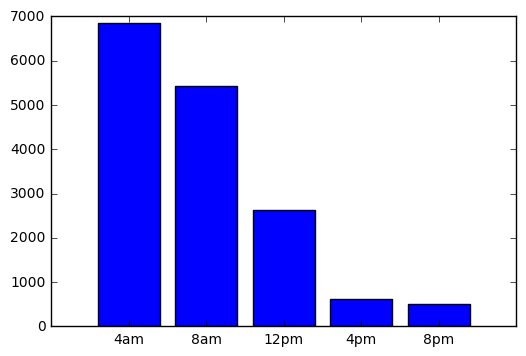

In [240]:
# 全体の平均を棒グラフで表示
print totaldist_with_clus
labels = ['4am', '8am', '12pm', '4pm', '8pm']
plt.bar([1,2,3,4,5], totaldist_with_clus, tick_label=labels, align='center')

([<matplotlib.axis.XTick at 0x7fca1eea6410>,
 <a list of 5 Text xticklabel objects>)

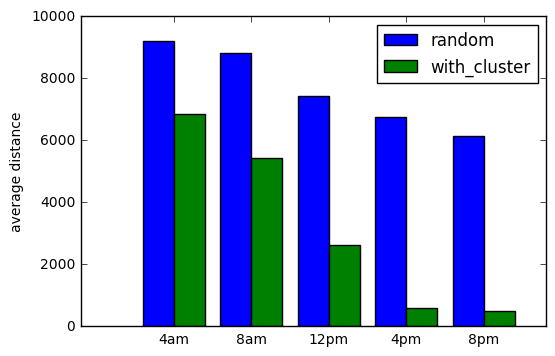

In [243]:
# グラフを合わせる
w = 0.4
X = numpy.arange(len(totaldist_random))
plt.bar(X, totaldist_random, color='b', width=w, label='random', align='center')
plt.bar(X+w, totaldist_with_clus, color='g', width=w, label='with_cluster', align='center')
plt.legend(loc="best")
plt.ylabel("average distance")
plt.xticks(X + w/2, ['4am', '8am', '12pm', '4pm', '8pm'])